In [2]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import re
import os
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences

In [38]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scikitplot.plotters as skplt
import os



In [4]:
#download the model to local so it can be used again and again
!mkdir -p module/module_elmo2
# Download the module, and uncompress it to the destination folder. 
!curl -L "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed" | tar -zxvC module/module_elmo2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
x assets/
x saved_model.pb
x tfhub_module.pb
x variables/
x variables/variables.index
100  331M  100  331M    0     0  2061k      0  0:02:44  0:02:44 --:--:-- 1878k25.5M    0     0  6367k      0  0:00:53  0:00:04  0:00:49 8507k    0  6542k      0  0:00:51  0:00:05  0:00:46 8196k0     0  2927k      0  0:01:55  0:00:35  0:01:20 1818kk      0  0:02:12  0:00:52  0:01:20 1811k70k      0  0:02:43  0:02:38  0:00:05 1741kk      0  0:02:44  0:02:43  0:00:01 1848k



In [39]:
FNC_Final= pd.read_csv('data/FNC_Final.csv')

In [15]:
FNC_Final.head()
FNC_Final.isnull().any()



Unnamed: 0                      False
Unnamed: 0.1                    False
Unnamed: 0.1.1                  False
id                              False
domain                          False
type                            False
url                             False
content                         False
scraped_at                      False
inserted_at                     False
updated_at                      False
title                            True
authors                          True
keywords                         True
meta_keywords                    True
meta_description                 True
tags                             True
summary                          True
source                           True
len_content                     False
len_title                       False
num_exclaim_title               False
num_sentences_content           False
sentences_content               False
num_paras                       False
num_punc_content                False
percent_punc

In [70]:
def cleanText(text):
    #remove EOL 
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text= text.split(" ")
    
    #remove stop words 
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    arr= np.array(text)
    # preprocess data to standardize lengths
    #text= text[0:999]
        
    #text=' '.join(text)
    
#     text = replace_contraction(text)
#     text = replace_links(text, "link")
#     text = remove_numbers(text)
#     text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
#     text = text.lower()
    return arr

In [ ]:
sentence_input = cleanText(FNC_Final['content'][0:1][0])
len (sentence_input)

In [ ]:
# create embeddings for one of the articles sentences from the FNC dataset
elmo = hub.Module("module/module_elmo2/", trainable=True)

sentence_input = list(cleanText(FNC_Final['content'][0:1][0]))

embeddings = elmo(
sentence_input,
signature="default",
as_dict=True)["elmo"]

embeddings = tf.reshape(embeddings,[-1,1024])

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    LifeIllusion = session.run(embeddings)
    
print(LifeIllusion)
print(LifeIllusion.shape)


In [40]:
FNC_Final['type'].count()


142395

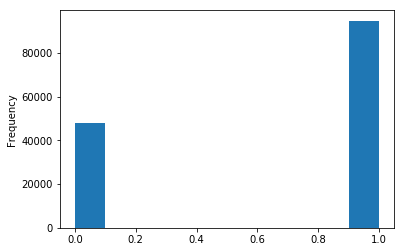

In [41]:
# change "reliable", "nan", and 'unkown' to 0
# change "rumor","hate","unreliable", etc. to 1
FNC_Final['label']= FNC_Final['type']
FNC_Final.loc[FNC_Final['type'] == 'reliable', 'label'] = 0
FNC_Final.loc[FNC_Final['type'] == 'satire', 'label'] = 1
FNC_Final.loc[FNC_Final['type'] == 'fake', 'label'] = 1
FNC_Final.loc[FNC_Final['type'] == 'bias', 'label'] = 1
FNC_Final.loc[FNC_Final['type'] == 'political', 'label'] = 1

# plot the distribution, as can be seen it is heavily skewed to fake news
FNC_Final['label'].plot.hist()


In [71]:
x = np.array(FNC_Final["content"].apply(cleanText))
y = np.array(FNC_Final["label"]) 

print(y[0])
print(x[0])


1
['VIEW' 'GALLERY' '' 'The' 'Boston' 'Celtics' 'traveling' 'west' 'coast'
 'battle' 'longtime' 'rival' 'LA' 'Lakers.' 'The' 'rivalry' 'dates' 'back'
 'days' 'Magic' 'vs.' 'Bird' 'grown' 'Kobe' 'vs.' 'Big' '3.' 'Now' 'time'
 'start' 'new' 'era' 'Lakers' 'Celtics' 'rivalry' 'names' 'like' 'Irving,'
 'Tatum,' 'Ball,' 'Ingram.' 'This' 'prove' '’em' 'game' 'Lakers' 'hot'
 'streak' 'winning' 'two' 'row' 'adding' 'another' 'big' 'W' 'C’s' 'could'
 'wonders' 'moving' 'forward.' 'The' 'Celtics' 'trying' 'snap' 'funk'
 'themselves,' 'nice' 'win' 'LA' 'might' 'trick.' '' 'The' 'Boston'
 'Celtics' '(34-13)' 'currently' 'three-game' 'losing' 'streak' 'fly'
 'Staples' 'Center.' 'The' 'Celtics' 'coming' 'four-game' 'home' 'stand'
 'went' '1-3,' 'west' 'coast' 'trip' 'lot' 'finish' 'first' 'half'
 'season.' 'Boston' 'lead' 'Kyrie' 'Irving' 'who’s' 'one' 'heck' 'season'
 'averaging' '24.5' 'points!' 'Al' 'Horford' 'low' 'key' 'leading'
 'Celtics' 'assists,' 'rebounds,' 'steals' 'per' 'game,' 'going' '

In [77]:
x[0]




array(['VIEW', 'GALLERY', '', 'The', 'Boston', 'Celtics', 'traveling',
       'west', 'coast', 'battle', 'longtime', 'rival', 'LA', 'Lakers.',
       'The', 'rivalry', 'dates', 'back', 'days', 'Magic', 'vs.', 'Bird',
       'grown', 'Kobe', 'vs.', 'Big', '3.', 'Now', 'time', 'start', 'new',
       'era', 'Lakers', 'Celtics', 'rivalry', 'names', 'like', 'Irving,',
       'Tatum,', 'Ball,', 'Ingram.', 'This', 'prove', '’em', 'game',
       'Lakers', 'hot', 'streak', 'winning', 'two', 'row', 'adding',
       'another', 'big', 'W', 'C’s', 'could', 'wonders', 'moving',
       'forward.', 'The', 'Celtics', 'trying', 'snap', 'funk',
       'themselves,', 'nice', 'win', 'LA', 'might', 'trick.', '', 'The',
       'Boston', 'Celtics', '(34-13)', 'currently', 'three-game',
       'losing', 'streak', 'fly', 'Staples', 'Center.', 'The', 'Celtics',
       'coming', 'four-game', 'home', 'stand', 'went', '1-3,', 'west',
       'coast', 'trip', 'lot', 'finish', 'first', 'half', 'season.',
       'Bosto

In [75]:
x= pad_sequences(x, value= "PAD", dtype=object, padding= 'post', truncating = 'post', maxlen=1000)



In [76]:
print(len(x[0]))
print(x.shape)


1000
(142395, 1000)


In [78]:
# split data into train and test

msk = np.random.rand(len(x)) < 0.8
x_train = x[msk]
x_test = x[~msk]

y_train = y[msk]
y_test = y[~msk]

#train_data = train[['content','type']].copy()
#test_data = test[['content','type']].copy()

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
#print(train_data['type'].head(10))
#print(train_data['content'][0])

114036 114036
28359 28359


In [ ]:
#get embeddings for x 

elmo = hub.Module("module/module_elmo2/", trainable=True)

sentence_input = tf.constant(shape=[1], name='sentence_input')
embeddings = elmo(sentence_input,signature="default",as_dict=True)["elmo"]
embeddings = tf.reshape(embeddings,[-1,1024])
    

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    x[i]= session.run(embeddings)
    
print(LifeIllusion)
print(LifeIllusion.shape)

In [ ]:



x_test = pad_sequences(x_test, value= "PAD", dtype = 'str', padding= 'post', truncating = 'post', maxlen=1000)


In [ ]:
    np.save('xtr_shuffled.npy',xtr)
    np.save('xde_shuffled.npy',xde)
    np.save('xte_shuffled.npy',xte)
    np.save('yte_shuffled.npy',yte)
    np.save('ytr_shuffled.npy',ytr)
    np.save('yde_shuffled.npy',yde)

In [ ]:
# df = pd.read_csv("sentences.csv",encoding="latin")
# df = df[df["sentiment"]!="Neutral"]
# df.loc[df["sentiment"]=='Negative',"sentiment"]=0
# df.loc[df["sentiment"]=='Positive',"sentiment"]=1

In [ ]:
# import re
# def cleanText(text):
#     text = text.strip().replace("\n", " ").replace("\r", " ")
#     text = replace_contraction(text)
#     text = replace_links(text, "link")
#     text = remove_numbers(text)
#     text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
#     text = text.lower()
#     return text
# X = np.array(df["text"].apply(cleanText))
# y = np.array(df["sentiment"])

In [ ]:
# embed = hub.Module("module/module_elmo2")
# def ELMoEmbedding(x):
#     return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [ ]:
# def build_model(): 
#     input_text = Input(shape=(1,), dtype="string")
#     embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
#     dense = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
#     pred = Dense(1, activation='sigmoid')(dense)
#     model = Model(inputs=[input_text], outputs=pred)
#     model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#     return model
# model_elmo = build_model()

In [ ]:
# with tf.Session() as session:
#     K.set_session(session)
#     session.run(tf.global_variables_initializer())  
#     session.run(tf.tables_initializer())
#     history = model_elmo.fit(X, y, epochs=5, batch_size=256, validation_split = 0.2)
#     model_elmo.save_weights('./model_elmo_weights.h5')